


# **1. Import Libraries**






In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2-2. Unzip Dataset**

In [3]:
# from zipfile import ZipFile

# with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
#   zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [4]:
labels = []

X_train = []
y_train = []
X_test = []
y_test = []


trainPath = 'drive/MyDrive/brain_tumor_dataset'+'/Training/'
testPath = 'drive/MyDrive/brain_tumor_dataset'+'/Testing/'


for folder in os.listdir(trainPath):
    labels.append(folder)


for i in labels:
    labelPath = os.path.join(trainPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    labelPath = os.path.join(testPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays and Rescaling Pixel Values**

In [5]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

**2-5. Checking Shape of NumPy Arrays**

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 128, 128, 3) (5712,)
(1311, 128, 128, 3) (1311,)


**2-6. Visualizing Random Samples from the Dataset**

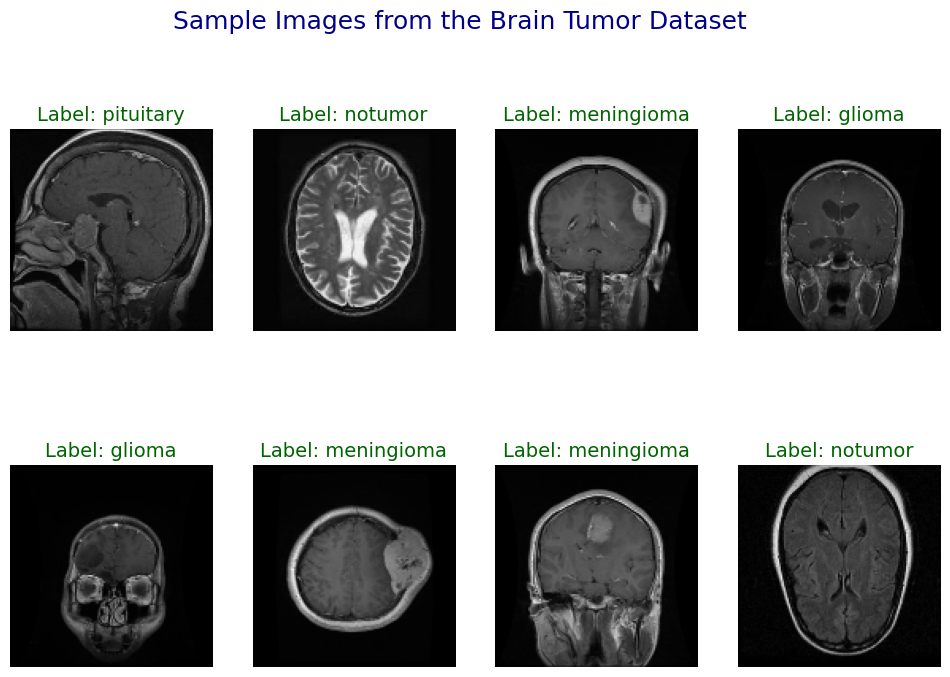

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images from the training set
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=18, color='darkblue')

for i in range(2):
    for j in range(4):
        random_index = np.random.randint(0, len(X_train))
        ax = axes[i, j]
        ax.imshow(X_train[random_index], cmap='plasma')  # Use a colormap for better visualization
        ax.set_title(f'Label: {y_train[random_index]}', fontsize=14, color='darkgreen')
        ax.axis('off')
plt.show()


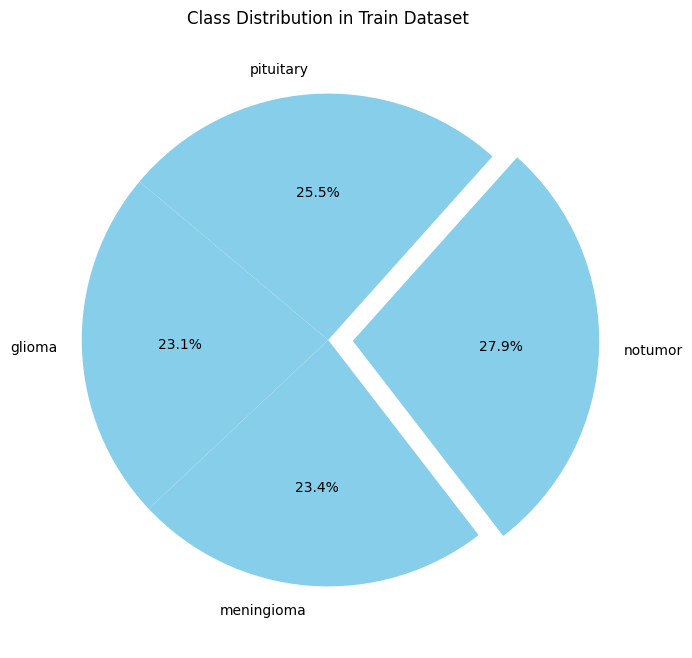

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_pie(labels, dataset_name):
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 8))
    colors = ['skyblue'] * len(unique_labels)  # Set all parts to the same color

    # Find the index of the largest slice
    explode = [0.1 if count == max(label_counts) else 0 for count in label_counts]

    # Set the border width for each wedge
    wedgeprops = {'linewidth': 2}

    plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops=wedgeprops)
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.show()

# Example usage
# Replace the placeholder below with your actual dataset and labels
plot_class_distribution_pie(y_train, "Train")


This pie chart visually represents the distribution of classes in the training dataset, helping to understand the balance or imbalance of class labels.

# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [9]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [10]:
# Let's shuffle the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)




*   There are 4855 samples in the training set, each with an image shape of 128x128 pixels and 3 channels (RGB). The corresponding labels have a shape of (4855, 4), indicating a one-hot encoded format for the 4 classes.
*   The testing set contains 1311 samples with the same image shape as the training set. The labels have a shape of (1311, 4), suggesting one-hot encoding for the 4 classes.
*   The validation set has 857 samples with images of the same dimensions. The labels are in a one-hot encoded format with a shape of (857, 4).

**3-4. Creating Training Data Generator**


*   **Zooming:** Zooming in and out can simulate variations in image resolution and focus.
*   **Horizontal and Vertical Flips:** Mirroring the images horizontally and vertically can help the model generalize better.
*   **Shearing:** Applying a small amount of shearing can simulate changes in the angle of the MRI scan.

In [12]:
train_datagen = ImageDataGenerator(
    fill_mode="nearest",
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)



train_datagenerator = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True
)

# **4. Network Architecture**

**4-1. Convolutional Neural Network Architecture**

In [17]:
# Create a Sequential model
model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(Flatten())


model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 256)       147712    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 256)      

this model consists of convolutional layers to extract features from input images, followed by fully connected layers for classification. The Adam optimizer is used for efficient gradient descent during training.

In this scenario:
- Added an extra convolutional layer
- Introduced a dropout layer for enhanced performance

In [18]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **5. Training**

**5-1. Early Stopping**

In [15]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**5-2. Training Convolutional Neural Network**

In [19]:
# history = model.fit(train_datagenerator, epochs =20, batch_size=32, validation_data=(X_val,y_val), callbacks=[early_stopping])
history = model.fit(train_datagenerator, epochs =30, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
137/137 [==============================] - 37s 195ms/step - loss: 0.9765 - accuracy: 0.5659 - val_loss: 1.2157 - val_accuracy: 0.5333
Epoch 2/30
137/137 [==============================] - 22s 160ms/step - loss: 0.6882 - accuracy: 0.7261 - val_loss: 0.6072 - val_accuracy: 0.7386
Epoch 3/30
137/137 [==============================] - 24s 173ms/step - loss: 0.5433 - accuracy: 0.7870 - val_loss: 0.6756 - val_accuracy: 0.7713
Epoch 4/30
137/137 [==============================] - 23s 167ms/step - loss: 0.4436 - accuracy: 0.8220 - val_loss: 0.4363 - val_accuracy: 0.8145
Epoch 5/30
137/137 [==============================] - 21s 155ms/step - loss: 0.3676 - accuracy: 0.8588 - val_loss: 0.3575 - val_accuracy: 0.8611
Epoch 6/30
137/137 [==============================] - 23s 169ms/step - loss: 0.2958 - accuracy: 0.8899 - val_loss: 0.3325 - val_accuracy: 0.8775
Epoch 7/30
137/137 [==============================] - 23s 168ms/step - loss: 0.2493 - accuracy: 0.9098 - val_loss: 0.3625 - val_ac


*   The model starts with relatively low accuracy and high loss, but it quickly improves over the first few epochs.
*   The training accuracy consistently increases, indicating that the model is learning from the training data.
*   The validation accuracy also improves but may fluctuate.
*   Towards the end of training, the model achieves high accuracy on both the training and validation sets, suggesting good learning and generalization.




# **6. Model Predictions**

**6-1. Predictions and Ground Truth Label Processing**

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

41/41 [==============================] - 3s 58ms/step


**6-2. Calculating Accuracy of CNN Model**

In [21]:

accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)


0.9549961861174676


 The model correctly predicted the class labels for approximately 95.94% of the samples in the test dataset.

# **7. Visualizing**

**7-1. Visualizing CNN Model Performance: Accuracy and Loss Over Epochs**

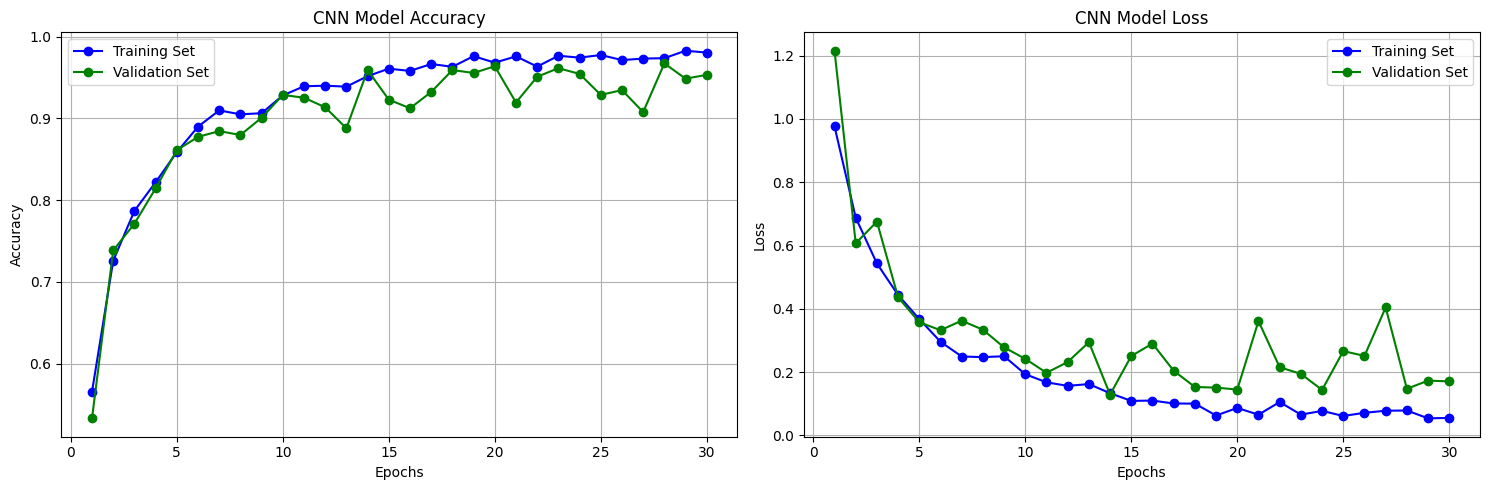

In [22]:
# Plot model performance with enhanced aesthetics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_acc, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_loss, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy and loss plots have fluctuations.
- Changing the learning rate reduces the fluctuation

**7-2. confusion Matrix**

41/41 [==============================] - 1s 18ms/step


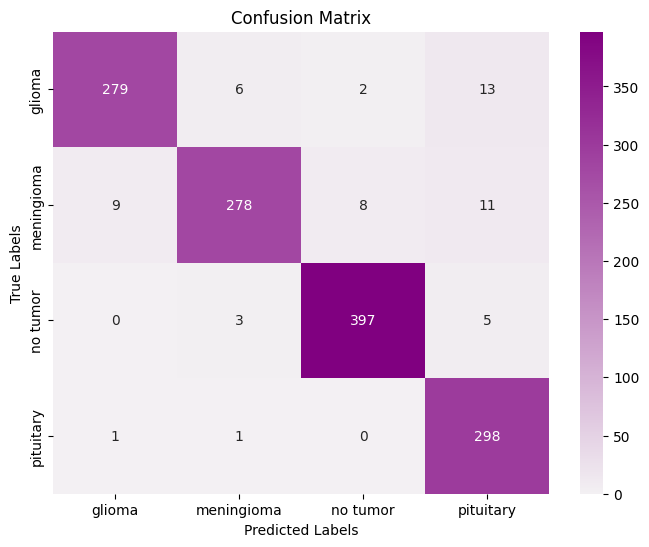

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
